# Description: 
This is a sentiment analysis program that parses the tweets fetched from Twitter using Python

In [0]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import re
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup

# !pip install -U spacy
# !pip install -U spacy-lookups-data
# !python -m spacy download en_core_web_sm
# en - load english language library and lg - load a large model
nlp = spacy.load('en_core_web_sm') 

In [2]:
# Load the data
from google.colab import files
uploaded = files.upload()

Saving Login.csv to Login (2).csv


In [0]:
# Get the data
log = pd.read_csv('Login.csv')

In [0]:
# Twitter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [0]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# Create the API object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [6]:
# Extract 100 tweets from the twitter user
posts = api.user_timeline(screen_name = "BillGates", count = 100, lang = "en", tweet_mode = "extended")

# Print the last 5 tweets from the account
print("Show the 5 recents tweets: \n")
i = 1
for tweet in posts[0:5]:
  print(str(i) + ') ' + tweet.full_text + "\n")
  i = i + 1

Show the 5 recents tweets: 

1) @narendramodi @gatesfoundation Thank you for the conversation and partnership, @narendramodi. Combating the pandemic requires global collaboration. India’s role is key as the world works to minimize social and economic impact, and pave the way to vaccine, testing, and treatment access for all. @PMOIndia

2) I’m hopeful that this program will improve our understanding of the coronavirus outbreak in Seattle and provide valuable information about the virus for other communities around the world. https://t.co/wnFarp28ys

3) RT @melindagates: When will America be able to get back to work? 

The answer depends on whether workers have caregiving options they can r…

4) Class of 2020, these are not easy times. But we will get through them. And with your leadership, the world will be stronger than before. https://t.co/rypFlsAles

5) RT @melindagates: To overcome #COVID19 the world doesn’t just need science. It needs a commitment to help people beat this virus whe

In [7]:
# Create a dataframe with a column called Tweets
df = pd.DataFrame([tweet.full_text for tweet in posts], columns = ['Tweets'])

# Show the first 5 rows of data
df.head()

,Tweets
0,@narendramodi @gatesfoundation Thank you for t...
1,I’m hopeful that this program will improve our...
2,RT @melindagates: When will America be able to...
3,"Class of 2020, these are not easy times. But w..."
4,RT @melindagates: To overcome #COVID19 the wor...


## `Preprocessing` and `Cleaning` Tweets

In [0]:
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}



In [0]:
## Conversion of contraction to Expansion
def cont_to_expa(x):
    if type(x) is str:
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
    else:
        return x 


## Remove Accented Chars
import unicodedata
def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'igonore')
    return x


# Convert into base or root form of word
def make_to_base(x):
    x_list = []
    doc = nlp(x)

    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text
        x_list.append(lemma)
    print(" ".join(x_list))

In [10]:
# Clean the text
# Create a function to clean the tweets
def prep_clean(text):

    text = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', text) # Remove emails
    text = re.sub(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)', '', text) # Remove urls
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = " ".join(text.split()) # Remove multiple space
    text = BeautifulSoup(text, 'lxml').get_text() # Reomve HTML tags
    text = remove_accented_chars(text) # Remove Accented Chars
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removed @mentioned
    text = re.sub(r'#', '', text) # Removing the '#' symbol
    text = re.sub('[^A-Z a-z 0-9-]+', '', text) # Special characters or punctuation removal

    text = text.lower()
    text = cont_to_expa(text) # Contraction to Expansion
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])

    return text

# Cleaning the text
df['Tweets'] = df['Tweets'].apply(lambda text: prep_clean(text))

# Show the cleaned text
df.head()

,Tweets
0,thank conversation partnership combating pande...
1,im hopeful program improve understanding coron...
2,america able work answer depends workers careg...
3,class 2020 easy times leadership world stronger
4,overcome covid19 world doesnt need science nee...


In [11]:
### check
x = 'thanks     for watching .   @email        and please  like this         video!!!'
prep_clean(x)

'thanks watching like video'

In [12]:
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with the new columns
df

,Tweets,Subjectivity,Polarity
0,thank conversation partnership combating pande...,0.316667,0.058333
1,im hopeful program improve understanding coron...,0.000000,0.000000
2,america able work answer depends workers careg...,0.625000,0.500000
3,class 2020 easy times leadership world stronger,0.833333,0.433333
4,overcome covid19 world doesnt need science nee...,0.000000,0.000000
...,...,...,...
95,world incredible strides ending aids epidemic ...,0.900000,0.900000
96,auto parts maker chattanooga tennessee saw fac...,0.540000,0.160000
97,dr leandrea ware energetic school leaders ive ...,0.375000,0.250000
98,getting closer having blood test alzheimers he...,0.500000,0.000000


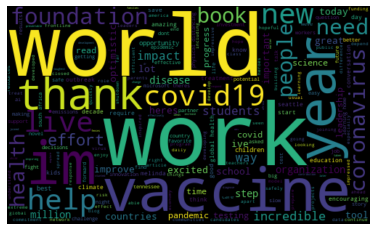

In [13]:
# Plot the Word Cloud
allWords = ' '.join([twts for twts in df['Tweets']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [14]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

df['Analysis'] = df['Polarity'].apply(getAnalysis)

# show the dataframe
df

,Tweets,Subjectivity,Polarity,Analysis
0,thank conversation partnership combating pande...,0.316667,0.058333,Positive
1,im hopeful program improve understanding coron...,0.000000,0.000000,Neutral
2,america able work answer depends workers careg...,0.625000,0.500000,Positive
3,class 2020 easy times leadership world stronger,0.833333,0.433333,Positive
4,overcome covid19 world doesnt need science nee...,0.000000,0.000000,Neutral
...,...,...,...,...
95,world incredible strides ending aids epidemic ...,0.900000,0.900000,Positive
96,auto parts maker chattanooga tennessee saw fac...,0.540000,0.160000,Positive
97,dr leandrea ware energetic school leaders ive ...,0.375000,0.250000,Positive
98,getting closer having blood test alzheimers he...,0.500000,0.000000,Neutral


In [0]:
# # Print all of the positive tweets
# j = 1
# sortedDF = df.sort_values(by=['Polarity'])
# for i in range(0, sortedDF.shape[0]):
#   if (sortedDF['Analysis'][i] == 'Positive'): 
#     print(str(j) + ') ' + sortedDF['Tweets'][i])
#     print()
#     j = j + 1

In [16]:
# print the negative tweets
j = 1
sortedDF = df.sort_values(by=['Polarity'], ascending = False)
for i in range(0, sortedDF.shape[0]):
  if (sortedDF['Analysis'][i] == 'Negative'):
    print(str(j) + ') '+ sortedDF['Tweets'][i])
    print()
    j = j + 1

1) halting funding world health organization world health crisis dangerous sounds work slowing spread covid-19 work stopped organization replace world needs

2) enjoy chatting sit little bit apart usual time

3) extreme physical distancing measures big difference need consistent nationwide approach case numbers start americawhich 10 weeks moreno continue business usual relax shutdown

4) science giving opportunity improve lives world faster today honored speech subject annual meeting aaasmtg

5) world work slow coronavirus outbreak protect vulnerable develop tools control ep

6) game

7) great microsofts leadership area avoiding worst effects climate change require innovation investment net zero carbon emissions sectors economy

8) deeply moved tayari joness story married couple lives torn apart incident injustice book well-written youll find sucked despite heavy subject matter



Text(0, 0.5, 'Subjectivity')

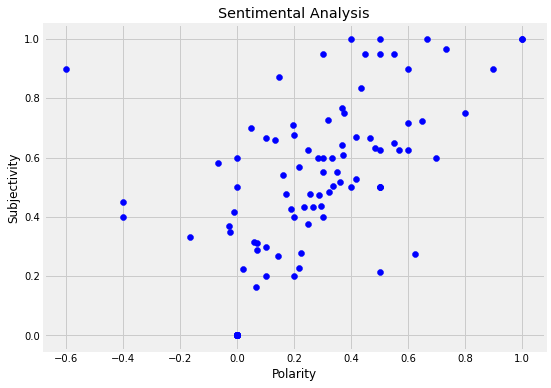

In [17]:
# Plot the polarity and subjectivity
plt.figure(figsize=(8, 6))
for i in range(0, df.shape[0]):
  plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color = 'Blue')

plt.title("Sentimental Analysis")
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [18]:
# Get the percentage of positive tweets
ptweets = df[df.Analysis == 'Positive']
ptweets = ptweets['Tweets']

round((ptweets.shape[0] / df.shape[0]) * 100, 1)

74.0

In [19]:
# Get the percentage of negative tweets
ntweets = df[df.Analysis == 'Negative']
ntweets = ntweets['Tweets']

round((ntweets.shape[0] / df.shape[0]) * 100, 1)

8.0

Positive    74
Neutral     18
Negative     8
Name: Analysis, dtype: int64


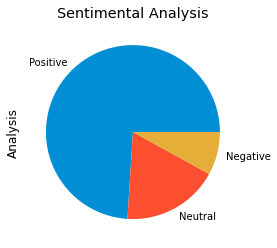

In [25]:
# Show the value counts
print(df['Analysis'].value_counts())

# plot and visualize the counts
plt.title('Sentimental Analysis')
df['Analysis'].value_counts().plot(kind='pie')
plt.show()